## Building an Isolation Forest Anomaly Detection Model

This notebook builds an Isolation Forest model, an unsupervised machine learning approach that can be used for anomaly detection. The model is then saved to the Project specifying a custom software specification. We then add a label to our original data to be used as training data.

We will be using the library `pyod` which isn't installed by default. The follow code installs the library to make it available for us to use.

In [1]:
!pip -q install pyod

We import the majority of the libraries we need, this include `pandas`, `numpy`, `pyplot` from `matplotlib` and various parts of `sklearn`.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

### Data Preprocessing

We read in the training data and then view the first few rows.

In [4]:
df = pd.read_csv("/project_data/data_asset/vaccine_anomaly_data.csv")
df.head()

,temperature,ambiant_temperature,kilowatts,oxygen_level,nitrogen_level,carbon_dioxide_level,humidity_level,fan_1,vent_2
0,4.733205,19.048409,4.504522,1,3,22.236375,76.979873,40.152803,4.180583
1,4.470511,19.331282,2.790023,1,6,20.094502,78.145180,40.456544,4.158029
2,4.913601,21.418761,5.023641,1,6,22.491557,77.910635,39.014223,3.097843
3,4.390718,20.215180,2.049018,1,3,20.708572,78.413976,40.594922,3.088171
4,3.872504,18.283026,1.547634,1,6,22.338767,78.424100,38.917349,1.495179


As you can see, the training data doesn't have a label indicating whether or not the row is an outlier of not.

We split the data into training and test. We build a model on training data and then use the test data to validate if our solution generalizes to previously unseen data. We are assigning 70% of our rows to training and 30% to test.

In [5]:
train, test = train_test_split(df, test_size=0.30, random_state=123)

We can view the column names.

In [6]:
train.columns

Index(['temperature', 'ambiant_temperature', 'kilowatts', 'oxygen_level',
       'nitrogen_level', 'carbon_dioxide_level', 'humidity_level', 'fan_1',
       'vent_2'],
      dtype='object')

We are creating a `ColumnTransformer`. Usually a column transformer will have multiple preprocessing steps and you can specify which columns are relevent for each step. In our care we only have a scaler and all columns are to be transformed.

In [7]:
ct = ColumnTransformer([
        ('scaler', StandardScaler(), ['temperature', 'ambiant_temperature', 'kilowatts',
       'oxygen_level', 'carbon_dioxide_level', 'nitrogen_level',
       'humidity_level', 'fan_1', 'vent_2'])
    ], remainder='passthrough')

### Build and Train Pipeline

We import the isolation forest method (IForest) from `pyod`.

In [8]:
from pyod.models.iforest import IForest

We create an instance of `IForest` which will be trained on our training data. We specify the contamination rate, what proportion of the data we expect to be anomalies. To ensure you're model predictions are accurate, you may want to explore the best value for this parameter. For the sake of this demo notebook, we are specifying as 0.05, i.e. 5% outliers.

In [9]:
iforestmodel = IForest(behaviour="new", contamination=0.05) 

We join the column transformer and model into a pipeline.

In [10]:
pipe = Pipeline([('columntransformer', ct), ('iforest', iforestmodel)])

We fit the pipeline to the training data.

In [11]:
pipe.fit(train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['temperature',
                                                   'ambiant_temperature',
                                                   'kilowatts', 'oxygen_level',
                                                   'carbon_dioxide_level',
                                                   'nitrogen_level',
                                                   'humidity_level', 'fan_1',
                                                   'vent_2'])])),
                ('iforest',
                 IForest(behaviour='new', bootstrap=False, contamination=0.05,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=1,
    random_state=None, verbose=0))])

### Explore Predictions

The `pyod` model will provide values indicating a distance. Above a particular threshold, a data point will be predicted to be an anomaly, lower than this it is normal. We use `decision_fuction` to capture this distance value for each training row.

In [12]:
y_train_scores = pipe.decision_function(train)
y_train_scores = pd.Series(y_train_scores)

Similarly we calculate the distance value for the test data.

In [13]:
y_test_scores = pipe.decision_function(test)
y_test_scores = pd.Series(y_test_scores)

We can create a copy of our training data and add a new column for the distance value, as well as add a column for the prediction. 

In [14]:
train_iforest = train.copy().reset_index()
train_iforest['distance'] = y_train_scores
train_iforest['pred'] = pipe.predict(train)

We repeat for the test data.

In [15]:
test_iforest = test.copy().reset_index()
test_iforest['distance'] = y_test_scores
test_iforest['pred'] = pipe.predict(test)

We can check what the prediction values can be.

In [16]:
test_iforest['pred'].unique()

array([0, 1])

A 1 indicates an outlier (/anomaly) and a 0 indicates inlier (/normal).

To create graphs, we check what the minimum and maximum distance values are.

In [17]:
print(train_iforest['distance'].min(), train_iforest['distance'].max())

-0.1769636408205062 0.10019231762377423


We can separate our data into regular and anomaly data, depending on the assign predictions.

In [18]:
danomaly = train_iforest[train_iforest['pred'] == 1.]['distance']
dregular = train_iforest[train_iforest['pred'] == 0.]['distance']

We then plot the frequency of data points for each distance value and use the color orange to indicate which are predicted to be inliers and blue to indicate which are predicted to be outliers.

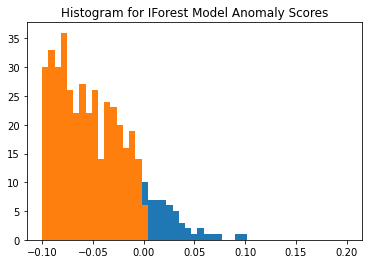

In [19]:
bins = np.linspace(-0.10, 0.20)
plt.hist(danomaly, bins=bins)
plt.hist(dregular, bins=bins)
plt.title("Histogram for IForest Model Anomaly Scores")
plt.show()

This process could be repeated to decide on the best contamination value. Alternatively, if you capture labels indicating outliers for this data, you could replace the predictions with the true labels and see where the majority of them sit.

We repeat for test data.

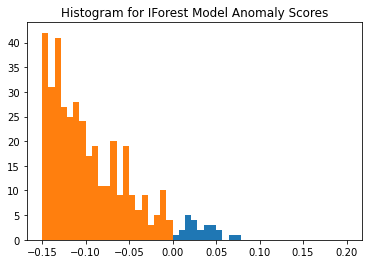

In [20]:
dtanomaly = test_iforest[test_iforest['pred'] == 1.]['distance']
dtregular = test_iforest[test_iforest['pred'] == 0.]['distance']
bins = np.linspace(-0.15, 0.20)
plt.hist(dtanomaly, bins=bins)
plt.hist(dtregular, bins=bins)
plt.title("Histogram for IForest Model Anomaly Scores")
plt.show()

### Save Model to Project

Next we save the model to the project. The below code imports the Watson Machine Learning library and creates a client using the required credential information.

In [21]:
from ibm_watson_machine_learning import APIClient
import os

token = os.environ['USER_ACCESS_TOKEN']

wml_credentials = {
    "token": token,
    "instance_id" : "openshift",
    "url": os.environ['RUNTIME_ENV_APSX_URL'],
    "version": "3.5"
}

wml_client = APIClient(wml_credentials)

The following code uses the `project_lib` library to capture the ID for the current project.

In [22]:
from project_lib import Project
project = Project.access()
project_id = project.get_metadata()['metadata']['guid']    

We tell the Watson Machine learning client that it should use this Project for accessing software specifications and saving our model.

In [23]:
wml_client.set.default_project(project_id)

'SUCCESS'

We list all software specifications available in this project to locate the `ASSET_ID` for our custom software specification that has `pyod` included.

In [24]:
wml_client.software_specifications.list()

-----------------------------  ------------------------------------  -------
NAME                           ASSET_ID                              TYPE
default_py3.6                  0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base
pytorch-onnx_1.3-py3.7-edt     069ea134-3346-5748-b513-49120e15d288  base
scikit-learn_0.20-py3.6        09c5a1d0-9c1e-4473-a344-eb7b665ff687  base
spark-mllib_3.0-scala_2.12     09f4cff0-90a7-5899-b9ed-1ef348aebdee  base
ai-function_0.1-py3.6          0cdb0f1e-5376-4f4d-92dd-da3b69aa9bda  base
shiny-r3.6                     0e6e79df-875e-4f24-8ae9-62dcc2148306  base
pytorch_1.1-py3.6              10ac12d6-6b30-4ccd-8392-3e922c096a92  base
scikit-learn_0.22-py3.6        154010fa-5b3b-4ac1-82af-4d5ee5abbc85  base
default_r3.6                   1b70aec3-ab34-4b87-8aa0-a4a3c8296a36  base
tensorflow_1.15-py3.6          2b73a275-7cbf-420b-a912-eae7f436e0bc  base
pytorch_1.2-py3.6              2c8ef57d-2687-4b7d-acce-01f94976dac1  base
spark-mllib_2.3                2e51

We capture the ID for our software specification.

In [25]:
software_spec_uid = '2b11bad7-14df-4872-8af1-8124bef95768'

Next we provide some metadata for our model, we provide the name we wish to give it, the software specification it should use and that it's type is `scikit-learn_0.23` as we used scikit-learn's Pipeline for our model.

In [26]:
MODEL_NAME="vaccine-anomaly-pyod-iforest-model"

metadata = {
    wml_client.repository.ModelMetaNames.NAME: MODEL_NAME,
    wml_client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_uid,
    wml_client.repository.ModelMetaNames.TYPE: "scikit-learn_0.23"
}

We store the model to the respository so that it is now available in the project.

In [27]:
model_details = wml_client.repository.store_model(pipe, meta_props=metadata,training_data=None, training_target=None)
model_details

{'entity': {'software_spec': {'id': '2b11bad7-14df-4872-8af1-8124bef95768',
   'name': 'Python 3.7 with pyod'},
  'type': 'scikit-learn_0.23'},
 'metadata': {'created_at': '2021-04-12T22:24:31.425Z',
  'id': '0e6ed878-9116-4e57-9b5f-1a050a40e781',
  'modified_at': '2021-04-12T22:24:32.700Z',
  'name': 'vaccine-anomaly-pyod-iforest-model',
  'owner': '1000331024',
  'project_id': '7bd837d2-f736-4a67-9a8a-8a95bbb37d9e'},
 'system': {'warnings': []}}

### Saving Training Data

As mentioned previously, we don't have true labels for our training data. However, we need to understand how accurate the model is before we deploy it. This should be done by evaluating the predictions. For example, you could provide a subset of values predicted to be inliers and others predicted to be outliers (with some focus on the boundary between the two) to subject matter experts to confirm or correct the predictions. Metrics such as accuracy, recall and precision could then be calculated on this dataset. If the size is large enough, this could then be used with binary classification methods to build another model.

For this demo we will create a copy of the original data and assume all predictions from our model are accurate, creating a column `anomaly` for our 'true' label.

In [28]:
df_pred = df.copy()

In [29]:
df_pred['anomaly'] = pipe.predict(df_pred)

we view the first few rows of this table.

In [30]:
df_pred.head()

,temperature,ambiant_temperature,kilowatts,oxygen_level,nitrogen_level,carbon_dioxide_level,humidity_level,fan_1,vent_2,anomaly
0,4.733205,19.048409,4.504522,1,3,22.236375,76.979873,40.152803,4.180583,0
1,4.470511,19.331282,2.790023,1,6,20.094502,78.145180,40.456544,4.158029,0
2,4.913601,21.418761,5.023641,1,6,22.491557,77.910635,39.014223,3.097843,0
3,4.390718,20.215180,2.049018,1,3,20.708572,78.413976,40.594922,3.088171,0
4,3.872504,18.283026,1.547634,1,6,22.338767,78.424100,38.917349,1.495179,0


We then save this to the project.

In [31]:
project.save_data("vaccine_anomaly_data_with_labels.csv", df_pred.to_csv(index=False), overwrite=True)

{'file_name': 'vaccine_anomaly_data_with_labels.csv',
 'message': 'File saved to project storage.',
 'asset_id': '84e1ee05-78a8-47fe-9372-c3e931ed8e42'}